<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/2_first_classifier_Train_last_paragraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [123]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


In [124]:
data = pd.read_csv("dca_for_classifier.csv")

In [125]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = data["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = data[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = data[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
print(rows_without_keyword["גוף המסמך"].to_string(index=False))

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

data = filtered_data

שורות שלא מכילות את הביטוי:

['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ר...
['פסק-דין בתיק רע"פ 2038/04 בבית המשפט העליון ר...
['פסק-דין בתיק רע"פ 5978/04 בבית המשפט העליון ר...

מספר השורות שנמחקו: 3

הנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'


In [126]:
import re

# פונקציה להמרת טקסט שמופיע כרשימה למחרוזת רגילה
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            # מנסה להמיר את התוכן בתוך הסוגריים לרשימה אמיתית
            text_list = ast.literal_eval(text)
            # איחוד המחרוזות לרצף טקסט אחד
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

# פונקציה לניקוי התווים המיותרים
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)  # הפיכת רשימה למחרוזת
    elif isinstance(text, str):
        # הסרת תווי רווח מיותרים ותווים מיוחדים
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים
        return text.strip()
    return text

# הדפסת שורות לא קריאות לפני המרה
print("שורות לא קריאות לפני המרה:")
print(data["גוף המסמך"].head())

# המרה של הטקסטים הלא קריאים לטקסטים קריאים ושמירה על הדאטה המקורי
data["גוף המסמך"] = data["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(data["גוף המסמך"].head())

# file_path = 'full_final_df_cleaned.csv'
# df_full_ra_rap.to_csv(file_path, index=False, encoding='utf-8')

# print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")

##########################################################################################

שורות לא קריאות לפני המרה:
1    ['פסק-דין בתיק רע"פ 8337/04 בבית המשפט העליון ...
2    ['החלטה בתיק רע"פ 7896/04 בבית המשפט העליון רע...
5    ['החלטה בתיק רע"פ 2985/04 בבית המשפט העליון בי...
6    ['החלטה בתיק רע"פ 110/04 בבית המשפט העליון רע"...
7    ['פסק דין בתיק רע"פ 2929/04 בבית המשפט העליון ...
Name: גוף המסמך, dtype: object

שורות לאחר המרה:
1    ['פסק-דין בתיק רע"פ 8337/04 בבית המשפט העליון ...
2    ['החלטה בתיק רע"פ 7896/04 בבית המשפט העליון רע...
5    ['החלטה בתיק רע"פ 2985/04 בבית המשפט העליון בי...
6    ['החלטה בתיק רע"פ 110/04 בבית המשפט העליון רע"...
7    ['פסק דין בתיק רע"פ 2929/04 בבית המשפט העליון ...
Name: גוף המסמך, dtype: object


In [127]:
data

,גוף המסמך,מספר תיק,Outcome of case,binary_outcome
1,"['פסק-דין בתיק רע""פ 8337/04 בבית המשפט העליון ...",8337/04,G R,1.0
2,"['החלטה בתיק רע""פ 7896/04 בבית המשפט העליון רע...",7896/04,G A,1.0
5,"['החלטה בתיק רע""פ 2985/04 בבית המשפט העליון בי...",2985/04,G A,1.0
6,"['החלטה בתיק רע""פ 110/04 בבית המשפט העליון רע""...",110/04,G A,1.0
7,"['פסק דין בתיק רע""פ 2929/04 בבית המשפט העליון ...",2929/04,G R substential matter that was resolved with ...,1.0
...,...,...,...,...
726,"['החלטה בתיק רע""פ 3076/07 בבית המשפט העליון רע...",3076/07,D,0.0
727,"['החלטה בתיק רע""פ 6415/07 בבית המשפט העליון רע...",6415/07,D A,0.0
728,"['החלטה בתיק רע""פ 825/07 בבית המשפט העליון רע""...",825/07,D A,0.0
729,"['החלטה בתיק רע""פ 4180/07 בבית המשפט העליון רע...",4180/07,D A,0.0


binary_outcome
0.0    680
1.0     43
Name: count, dtype: int64


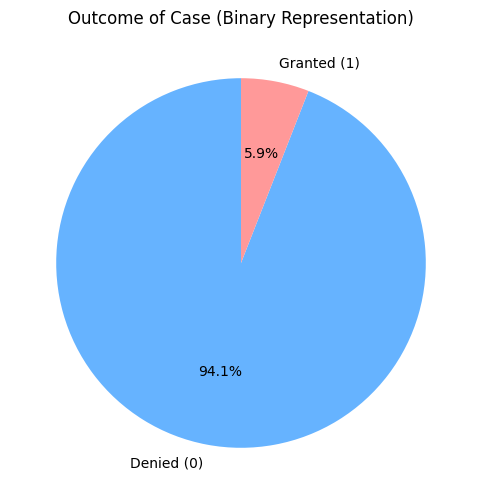

In [128]:
binary_counts = data['binary_outcome'].value_counts()
print(binary_counts)
labels = ['Denied (0)','Granted (1)']

plt.figure(figsize=(6, 6))
plt.pie(binary_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Outcome of Case (Binary Representation)')

plt.show()

In [129]:
# הגדרת פונקציה לעיצוב טקסט
def format_text(text, line_length=80):
    """
    פורמט טקסט כך שיהיה נוח לקריאה עם שורות שאורכן מוגבל.
    """
    import textwrap
    return "\n".join(textwrap.wrap(text, width=line_length))


In [130]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

In [131]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

## Only last paragraph modeling


In [132]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text):
    min_length = 500  # אורך מינימלי לשמירה
    last_sen = 30     # מספר תווים להסרה מסוף הטקסט

    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text


# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data = data.dropna(subset=["גוף המסמך", "binary_outcome"])

# חיתוך הטקסטים בעמודת "גוף המסמך"
data["גוף המסמך"] = data["גוף המסמך"].apply(trim_text)

# שמירת התוצאה לקובץ
file_path = 'final_trimmed_data.csv'
data.to_csv(file_path, index=False, encoding='utf-8')

print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


Streaming output truncated to the last 5000 lines.
, שכן העץ יכול להאפיל על מבנה של שניים או שלושה מ"ר לערך, אך הוא איננו יכול להאפ
יל על המבנה נשוא בקשת הערעור, אשר גודלו מתקרב לכדי 80 מ"ר. אשר-על-כן, דין בקשת ר
שות הערעור להידחות. ניתנה היום, ז\' באייר התשס"ז (25.4.2007). ש ו פ ט __________
_______________ העותק כפוף לשינויי עריכה וניסוח. 06102900_H03.doc /צש מרכז מידע,
 טל\' 02-6593666 ; א
##*******************************************************####
Trimmed Text (Original Length: 3093, Trimmed Length: 500):
 תיקון כולל, שייתן תשובה לבעיות השונות שעלו בעבר, שהפסיקה לגביהם אינה אחידה, ושי
נסה למצוא את שביל הזהב בין מציאות למשפט, בין טכנולוגיה לבטיחות." קיימנו שיח ושיג
 בנושא זה עם ב"כ המשיבה, שהבהיר כי הנושא נשקל על ידי הרשויות המוסמכות. חזקה על מ
חוקק המשנה שישלים את הבחינה הנדרשת במהירות הראויה. בכפוף להערתנו זו אנו דוחים את
 הבקשה. ניתנה היום, ט"ו באייר התשס"ז (3.5.07). ש ו פ ט ש ו פ ט ש ו פ ט _________
________________ העותק כפוף לשינויי עריכה וניסוח. 06063590_M04.doc נב מרכז מיד

<ipython-input-132-23b556bde541>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["גוף המסמך"] = data["גוף המסמך"].apply(trim_text)


In [133]:
data

,גוף המסמך,מספר תיק,Outcome of case,binary_outcome
1,צאנו כי יש מקום בנסיבות העניין ליתן רשותערעור ...,8337/04,G R,1.0
2,"ולם, לכל ברי כי אין הסוגיה מסבה עצמה אלא על שא...",7896/04,G A,1.0
5,"""ד שמעון שובר בשם המשיבה: עו""ד נעמי גרנות החלט...",2985/04,G A,1.0
6,זו לא התלבנה בפנינו ולכך שמנהלמקרקעי ישראל אי...,110/04,G A,1.0
7,"8. על כן, ואם תישמע דעתי, נחזיר על כנה את קביע...",2929/04,G R substential matter that was resolved with ...,1.0
...,...,...,...,...
726,התערבות בהחלטותיהן של הערכאות שקדמו לי. למבקשי...,3076/07,D,0.0
727,בבית משפט השלום לתעבורה לא היה סביר ולא הלם א...,6415/07,D A,0.0
728,"יכרת ממדיניות הענישה (ראו רע""פ 1174/97 עזרא רפ...",825/07,D A,0.0
729,"רובם, למי שהם אנשים נורמטיביים; אך העונש העיקר...",4180/07,D A,0.0


### Embedding

In [134]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


### Train and fit

In [135]:

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# שמירת אינדקסים מקוריים
resampled_indices = undersampler.sample_indices_
joblib.dump(resampled_indices, 'resampled_indices.pkl')

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

# התאמת המודל לנתונים המאוזנים
classifier.fit(X_resampled, y_resampled)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- לוגיקה למציאת threshold אופטימלי ---
predicted_probabilities = classifier.predict_proba(X_resampled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_resampled, predicted_probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold אופטימלי לפי F1 Score: {optimal_threshold}")

# שמירת יחס הכיתות המקורי
class_ratio_original = sum(y == 1) / len(y)
print(f"יחס כיתות מקורי (Class 1): {class_ratio_original:.2f}")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model.pkl')
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')
joblib.dump(class_ratio_original, 'class_ratio_original.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


Cross-Validation Accuracy: [1.         1.         0.91304348 1.         0.90909091]
Mean Accuracy: 0.9644268774703557
Cross-Validation Precision for Class 1: [1.         1.         0.88888889 1.         0.875     ]
Mean Precision for Class 1: 0.9527777777777778
Cross-Validation Recall for Class 1: [1.         1.         0.88888889 1.         0.875     ]
Mean Recall for Class 1: 0.9527777777777778
Cross-Validation F1 Score for Class 1: [1.         1.         0.88888889 1.         0.875     ]
Mean F1 Score for Class 1: 0.9527777777777778
Confusion Matrix with Labels:
True Negatives (TN): 69
False Positives (FP): 2
False Negatives (FN): 2
True Positives (TP): 41

Confusion Matrix:
[[69 2]
 [2 41]]
Threshold אופטימלי לפי F1 Score: 0.7298604296569804
יחס כיתות מקורי (Class 1): 0.06
המודל והמשאבים נשמרו בהצלחה.


### FN print


In [136]:
# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nDocument Body:")
    formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


False Negative Cases (True Label: 1, Predicted Label: 0):

Case 1:
--------------------------------------------------------------------------------
Index in Original Data:
279

Original Outcome of Case:
G A

Binary Outcome (True Label):
1.0

Predicted Label:
0.0

Document Body:
 בתיק רע"פ 3884/06 בבית המשפט העליון רע"פ 3884/06 - ו\' בפני: כבוד השופטת ע\' אר
בל המבקש: פיטר עספור נגד המשיבה: מדינת ישראל בקשה לדחיית ריצוי עונש המאסר בשם המ
בקש: עו"ד מ\' חסאן בשם המשיבה: עו"ד א\' וינשל החלטה בהסכמת המשיבה ידחה ריצוי עונ
שו של המבקש ליום 7.3.07. המקש יתייצב ביום זה עד שעה 10:00 במזכירות הפלילית בבית 
המשפט המחוזי בירושלים. ניתנה היום, ד\' באדר תשס"ז (22.2.07). ש ו פ ט ת _________
________________ העותק כפוף לשינויי עריכה וניסוח. 06038840_B07.doc עכ מרכז מידע,
 טל\' 02-6593666 ; א
--------------------------------------------------------------------------------

Case 2:
--------------------------------------------------------------------------------
Index in Original Data:
465

Original Outco